In [174]:
#!pip install pandas matplotlib scikit-learn torch torchvision
# if you get issues with importing torch, install it using conda using the following command
# conda install pytorch torchvision -c pytorch

In [175]:
#!pip install scikit-learn

In [176]:
import gzip
import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time as time_module

In [177]:
def load_dataframe_from_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None

def load_dataframe_from_gz(gz_file_path):
    # Decompress the .gz file and read its content
    with gzip.open(gz_file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

def filter_stock_data(data_frame, stock_tickers):
    filtered_data = data_frame[data_frame['SYMBOL'].isin(stock_tickers)]
    return filtered_data

def calculate_price_and_indicators(df1, indicators):
    df = df1.copy()
    
    bid_column, ask_column, sell_columns, buy_columns = 'BID_PRICE_1', 'ASK_PRICE_1', ['ASK_SIZE_1', 'ASK_SIZE_2', 'ASK_SIZE_3'], ['BID_SIZE_1', 'BID_SIZE_2', 'BID_SIZE_3']
    
    # Calculate the price change for BID and ASK separately
    df['BidPriceChange'] = df[bid_column].pct_change()    
    df['AskPriceChange'] = df[ask_column].pct_change()
    df['Spread'] = df[ask_column] - df[bid_column]
    df['SpreadChange'] = df['Spread'].pct_change()

    df['BidPriceDir'] = (df['BidPriceChange'] > 0).astype(int)
    df['AskPriceDir'] = (df['AskPriceChange'] > 0).astype(int)
    # df['SpreadChange'] = (df['SpreadChange'] > 0).astype(int)

    if 'OFI' in indicators:
        # Calculate OFI and add it to the copy of the DataFrame
        total_buy_volume = df[buy_columns].sum(axis=1)
        total_sell_volume = df[sell_columns].sum(axis=1)
        df['OFI'] = (total_buy_volume - total_sell_volume) / (total_buy_volume + total_sell_volume)
        
    
    if 'MACD' in indicators:
        mid_price = (df[bid_column] + df[ask_column]) / 2
        EMA_12 = mid_price.ewm(span=12, adjust=False).mean()  # Close column is assumed. Adjust if needed.
        EMA_26 = mid_price.ewm(span=26, adjust=False).mean()  # Close column is assumed. Adjust if needed.
        df['MACD'] = EMA_12 - EMA_26
        df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    if 'RSI' in indicators:
        # Calculate RSI for past 20 rows
        delta = df['BidPriceChange'] - df['AskPriceChange']
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=20).mean()
        avg_loss = loss.rolling(window=20).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
    
    if 'VWAP' in indicators:
        # VWAP Calculation (using first level bid and ask prices and sizes)
        total_volume = df['BID_SIZE_1'] + df['ASK_SIZE_1']
        total_price_volume = (df['BID_PRICE_1'] * df['BID_SIZE_1']) + (df['ASK_PRICE_1'] * df['ASK_SIZE_1'])
        df['VWAP'] = total_price_volume / total_volume
        
    if 'Volatility' in indicators:
        # Price Volatility (20-period rolling standard deviation of mid-price)
        mid_price = (df['BID_PRICE_1'] + df['ASK_PRICE_1']) / 2
        df['Volatility'] = mid_price.rolling(window=20).std()
        
    if 'EMA' in indicators:
        # Calculate EMA for past 20 rows
        df['EMA'] = df[bid_column].ewm(span=20, adjust=False).mean()

    # Filter the df with the data we need
    columns = ['COLLECTION_TIME', 'BID_PRICE_1', 'ASK_PRICE_1', 'BidPriceChange', 'AskPriceChange', 'SpreadChange', 'BidPriceDir', 'AskPriceDir'] + indicators
    df = df[columns]

    # Offset the price by 1 row so that the change is for the next row
    df['BidPriceChange'] = df['BidPriceChange'].shift(-1)
    df['AskPriceChange'] = df['AskPriceChange'].shift(-1)

    return df

def filter_time_window(df1, start_time, end_time):
    df = df1.copy()

    # Convert 'COLLECTION_TIME' column to datetime.time objects if it's not already
    if not isinstance(df['COLLECTION_TIME'].iloc[0], time):
        df['COLLECTION_TIME'] = pd.to_datetime(df['COLLECTION_TIME'])

    # Create the mask to filter the time window
    mask = (df['COLLECTION_TIME'] >= start_time) & (df['COLLECTION_TIME'] < end_time)
    return df[mask]

def find_max_trading_hour(df):
    # Get a list of all unique time values
    unique_times = sorted(df['COLLECTION_TIME'].unique())

    max_trades = 0
    best_start_time = None
    best_end_time = None

    # Iterate over unique time values to consider each as a potential start time for the 1-hour window
    for time in unique_times:
        # Calculate the corresponding end time for a 1-hour window
        time_datetime = pd.to_datetime(str(time))
        end_time_datetime = time_datetime + pd.Timedelta(hours=1)
        
        # Use the filter_time_window function to get the data within this 1-hour window
        window_df = filter_time_window(df, time_datetime, end_time_datetime)

        # If this window has more trades than previous max, update the best times and max_trades value
        if window_df.shape[0] > max_trades:
            max_trades = window_df.shape[0]
            best_start_time = time
            best_end_time = end_time_datetime

    return best_start_time, best_end_time

def plot_histograms(df, columns):
    # Create subplots to display histograms for each column
    fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 12))

    # Plot histograms for each column
    for i, column in enumerate(columns):
        ax = axes[i]
        ax.hist(df[column], bins=30, color='skyblue', edgecolor='black')
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def plot_histograms_and_stats(df, columns):
    
    color_cycle = itertools.cycle(['skyblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightpink', 'lightseagreen'])

    # Create subplots to display histograms for each column and statistics
    fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(12, 8))
    
    # Plot histograms for each column
    for i, column in enumerate(columns):
        ax_hist = axes[i, 0]
        ax_stats = axes[i, 1]

        # Get the next color from the color cycle
        color = next(color_cycle)

        # Plot histogram with the corresponding color
        ax_hist.hist(df[column], bins=30, color=color, edgecolor='black')
        ax_hist.set_title(f'Distribution of {column}')
        ax_hist.set_xlabel(column)
        ax_hist.set_ylabel('Frequency')

        # Calculate statistics
        num_zeros = (df[column] == 0).sum()
        num_positive = (df[column] > 0).sum()
        num_negative = (df[column] < 0).sum()

        # Display statistics
        stats_text = f"Zeros: {num_zeros}\nPositive: {num_positive}\nNegative: {num_negative}"
        ax_stats.text(0.5, 0.5, stats_text, fontsize=12, ha='center')
        ax_stats.axis('off')

    plt.tight_layout()
    plt.show()



In [178]:
# Example usage:
# deep_path = "book_snapshots/20211105_book_updates.csv"
deep_path = "sample_data/20211105_book_updates.csv.gz"
deep = load_dataframe_from_gz(deep_path)

# trades_path = "book_snapshots/20211105_trades.csv"
trades_path = "sample_data/20211105_trades.csv.gz"
trades = load_dataframe_from_gz(trades_path)

In [179]:
deep.head()

COLLECTION_TIME  MESSAGE_ID MESSAGE_TYPE SYMBOL  BID_PRICE_1  \
0  2021-11-05 13:30:00.002643968      254345   ASK_UPDATE   AAPL       147.66   
1  2021-11-05 13:30:00.005378048      254784   ASK_UPDATE     BA       206.57   
2  2021-11-05 13:30:00.009202944      255328   ASK_UPDATE    CVX       109.21   
3  2021-11-05 13:30:00.028035072      258608   ASK_UPDATE   CSCO        56.06   
4  2021-11-05 13:30:00.036359936      260240   ASK_UPDATE     VZ        51.13   

   BID_SIZE_1  BID_PRICE_2  BID_SIZE_2  BID_PRICE_3  BID_SIZE_3  ASK_PRICE_1  \
0         100       146.74         100       145.10         100       153.82   
1         100       201.19         100       195.80         100       217.71   
2         100       108.89         100       107.25         100       115.86   
3         200        55.18         300        54.30         100        58.18   
4         200        50.52         400        49.92         600        52.57   

   ASK_SIZE_1  ASK_PRICE_2  ASK_SIZE_2  ASK_PRICE_3  ASK_SIZE_3  
0         100       154.74         100       156.38         100  
1         312       224.87         100       230.26         100  
2         100       116.56         100       117.81         100  
3         200        59.06         300        59.94         100  
4         200        53.18         500        53.78         900

In [180]:
trades.head()

COLLECTION_TIME  MESSAGE_ID MESSAGE_TYPE SYMBOL   PRICE  \
0  2021-11-05 12:00:06.131293952       46385            T    MRK   82.67   
1  2021-11-05 12:01:55.289646080       48451            T    MRK   82.68   
2  2021-11-05 12:01:58.548282880       48480            T    MRK   82.45   
3  2021-11-05 12:03:32.804205056       49650            T    MRK   82.33   
4  2021-11-05 12:04:01.764555008       49949            T     GS  410.39   

   SIZE  TRADE_ID                               TRADE_FLAGS  
0    50   2421377                    EXTENDED_HOURS|ODD_LOT  
1    70   2754088  INTERMARKET_SWEEP|EXTENDED_HOURS|ODD_LOT  
2    35   2760292                    EXTENDED_HOURS|ODD_LOT  
3    70   2926673                    EXTENDED_HOURS|ODD_LOT  
4    25   2969619                    EXTENDED_HOURS|ODD_LOT

In [181]:

stock_tickers_list = ['AAPL'] # we can can add more
aapl = filter_stock_data(deep, stock_tickers_list)
aapl_trades = filter_stock_data(trades, stock_tickers_list)

In [182]:
aapl

COLLECTION_TIME  MESSAGE_ID MESSAGE_TYPE SYMBOL  \
0        2021-11-05 13:30:00.002643968      254345   ASK_UPDATE   AAPL   
6        2021-11-05 13:30:00.097841920      267082   BID_UPDATE   AAPL   
8        2021-11-05 13:30:00.134350080      268339   ASK_UPDATE   AAPL   
17       2021-11-05 13:30:00.267025920      275160   ASK_UPDATE   AAPL   
18       2021-11-05 13:30:00.267388928      275161   ASK_UPDATE   AAPL   
...                                ...         ...          ...    ...   
1834637  2021-11-05 19:59:56.181732096    99775451   BID_UPDATE   AAPL   
1834768  2021-11-05 20:00:00.060007936    99844843   BID_UPDATE   AAPL   
1834770  2021-11-05 20:00:00.062027008    99845130   BID_UPDATE   AAPL   
1834771  2021-11-05 20:00:00.062027008    99845136   ASK_UPDATE   AAPL   
1834772  2021-11-05 20:00:00.062027008    99845143   BID_UPDATE   AAPL   

         BID_PRICE_1  BID_SIZE_1  BID_PRICE_2  BID_SIZE_2  BID_PRICE_3  \
0             147.66         100       146.74         100       145.10   
6             151.80         100       147.66         100       146.74   
8             151.80         100       147.66         100       146.74   
17            151.80         100       147.66         100       146.74   
18            151.80         100       147.66         100       146.74   
...              ...         ...          ...         ...          ...   
1834637       149.93          10       135.00         300       133.00   
1834768       149.93          10       135.00         300       133.00   
1834770       149.93          10       135.00         100       133.00   
1834771       149.93          10       135.00         100       133.00   
1834772       149.93          10       135.00         100       133.00   

         BID_SIZE_3  ASK_PRICE_1  ASK_SIZE_1  ASK_PRICE_2  ASK_SIZE_2  \
0               100       153.82         100       154.74         100   
6               100       153.82         100       154.74         100   
8               100       151.88         100       153.82         100   
17              100       151.87         100       151.88         100   
18              100       151.87         100       153.82         100   
...             ...          ...         ...          ...         ...   
1834637         100       152.60          83       153.00         100   
1834768         100       152.60          83       153.00         100   
1834770         100       152.60          83       153.00         100   
1834771         100       152.60          83       153.00         100   
1834772         100       152.60          83       153.00         100   

         ASK_PRICE_3  ASK_SIZE_3  
0             156.38         100  
6             156.38         100  
8             154.74         100  
17            153.82         100  
18            154.74         100  
...              ...         ...  
1834637       153.50         135  
1834768       153.50         135  
1834770       153.50         135  
1834771       153.50         135  
1834772       153.50         135  

[287195 rows x 16 columns]

In [183]:
aapl_trades

COLLECTION_TIME  MESSAGE_ID MESSAGE_TYPE SYMBOL  \
167     2021-11-05 12:32:34.894304000       76934            T   AAPL   
175     2021-11-05 12:32:42.993463040       77421            T   AAPL   
176     2021-11-05 12:32:42.993487872       77422            T   AAPL   
177     2021-11-05 12:32:42.993498880       77423            T   AAPL   
179     2021-11-05 12:33:05.645682944       78143            T   AAPL   
...                               ...         ...          ...    ...   
117016  2021-11-05 19:59:49.718188032    99652861            T   AAPL   
117142  2021-11-05 19:59:51.058637056    99691230            T   AAPL   
117176  2021-11-05 19:59:51.969824000    99711779            T   AAPL   
117210  2021-11-05 19:59:52.653321984    99722999            T   AAPL   
117322  2021-11-05 19:59:55.555063040    99766060            T   AAPL   

          PRICE  SIZE    TRADE_ID                              TRADE_FLAGS  
167     151.040     1     7836467                   EXTENDED_HOURS|ODD_LOT  
175     151.100    50     7914905                   EXTENDED_HOURS|ODD_LOT  
176     151.110    10     7914910                   EXTENDED_HOURS|ODD_LOT  
177     151.110    10     7914915                   EXTENDED_HOURS|ODD_LOT  
179     151.130    10     8105889                   EXTENDED_HOURS|ODD_LOT  
...         ...   ...         ...                                      ...  
117016  151.250   300  2621245728          INTERMARKET_SWEEP|REGULAR_HOURS  
117142  151.255   100  2622347824                            REGULAR_HOURS  
117176  151.260    15  2622835680  INTERMARKET_SWEEP|REGULAR_HOURS|ODD_LOT  
117210  151.270   171  2623157955          INTERMARKET_SWEEP|REGULAR_HOURS  
117322  151.260   100  2624523981          INTERMARKET_SWEEP|REGULAR_HOURS  

[6568 rows x 8 columns]

In [184]:

indicators = ['OFI', 'RSI', 'MACD', 'VWAP', 'Volatility', 'EMA']
factors = calculate_price_and_indicators(aapl, indicators)

In [185]:
# factors

In [186]:

start, end = find_max_trading_hour(aapl_trades)
print(f"The 1-hour window with the highest trading activity is from {start} to {end}.")
filtered_factors = filter_time_window(factors, start, end)

The 1-hour window with the highest trading activity is from 2021-11-05 18:59:54.937584896 to 2021-11-05 19:59:54.937584896.


In [187]:
filtered_factors

COLLECTION_TIME  BID_PRICE_1  ASK_PRICE_1  \
1509878 2021-11-05 18:59:57.196998912       150.60       150.62   
1509880 2021-11-05 18:59:57.197445888       150.61       150.62   
1509881 2021-11-05 18:59:57.197447936       150.61       150.62   
1509882 2021-11-05 18:59:57.197448960       150.61       150.62   
1509883 2021-11-05 18:59:57.197449984       150.61       150.62   
...                               ...          ...          ...   
1834483 2021-11-05 19:59:54.110448128       149.93       152.00   
1834526 2021-11-05 19:59:54.511262976       151.26       152.00   
1834543 2021-11-05 19:59:54.615781888       149.93       152.00   
1834544 2021-11-05 19:59:54.661307904       149.93       152.00   
1834546 2021-11-05 19:59:54.828104960       149.93       152.00   

         BidPriceChange  AskPriceChange  SpreadChange  BidPriceDir  \
1509878        0.000066             0.0      0.000000            0   
1509880        0.000000             0.0     -0.500000            1   
1509881        0.000000             0.0      0.000000            0   
1509882        0.000000             0.0      0.000000            0   
1509883        0.000000             0.0      0.000000            0   
...                 ...             ...           ...          ...   
1834483        0.008871             0.0      1.760000            0   
1834526       -0.008793             0.0     -0.642512            1   
1834543        0.000000             0.0      1.797297            0   
1834544        0.000000             0.0      0.000000            0   
1834546        0.008938             0.0      0.000000            0   

         AskPriceDir       OFI        RSI      MACD        VWAP  Volatility  \
1509878            0  0.703704  49.888999  0.013898  150.600119    0.105362   
1509880            0  0.744557  50.250352  0.008625  150.610291    0.105288   
1509881            0  0.701188  50.250352  0.004395  150.610291    0.105213   
1509882            0  0.802025  50.250352  0.001031  150.610074    0.105137   
1509883            0  0.701188  50.250352 -0.001616  150.610074    0.105061   
...              ...       ...        ...       ...         ...         ...   
1834483            0 -0.900744  45.135739 -0.016644  151.901429    0.327480   
1834526            0  0.232465  52.714008  0.024703  151.445000    0.335030   
1834543            0 -0.900744  45.236529  0.003768  151.901429    0.333000   
1834544            0 -0.097421  48.749535 -0.012678  151.901429    0.325693   
1834546            0  0.034048  48.810689 -0.025418  151.901429    0.317368   

                EMA  
1509878  150.599775  
1509880  150.600749  
1509881  150.601630  
1509882  150.602427  
1509883  150.603148  
...             ...  
1834483  150.582954  
1834526  150.647435  
1834543  150.579108  
1834544  150.517288  
1834546  150.461356  

[49356 rows x 14 columns]

In [188]:
len(filtered_factors)

49356

In [189]:
49356/60

822.6

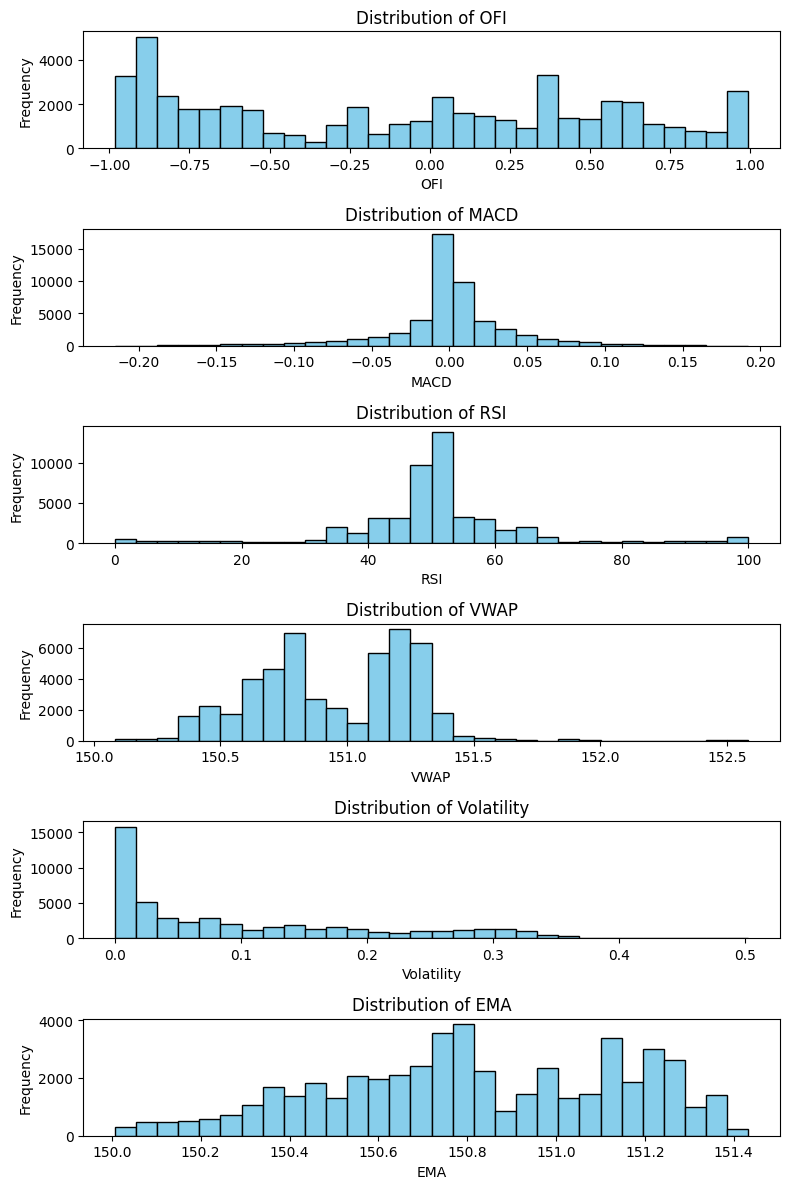

In [190]:
columns = ['OFI', 'MACD', 'RSI', 'VWAP', 'Volatility', 'EMA']
plot_histograms(filtered_factors, columns)


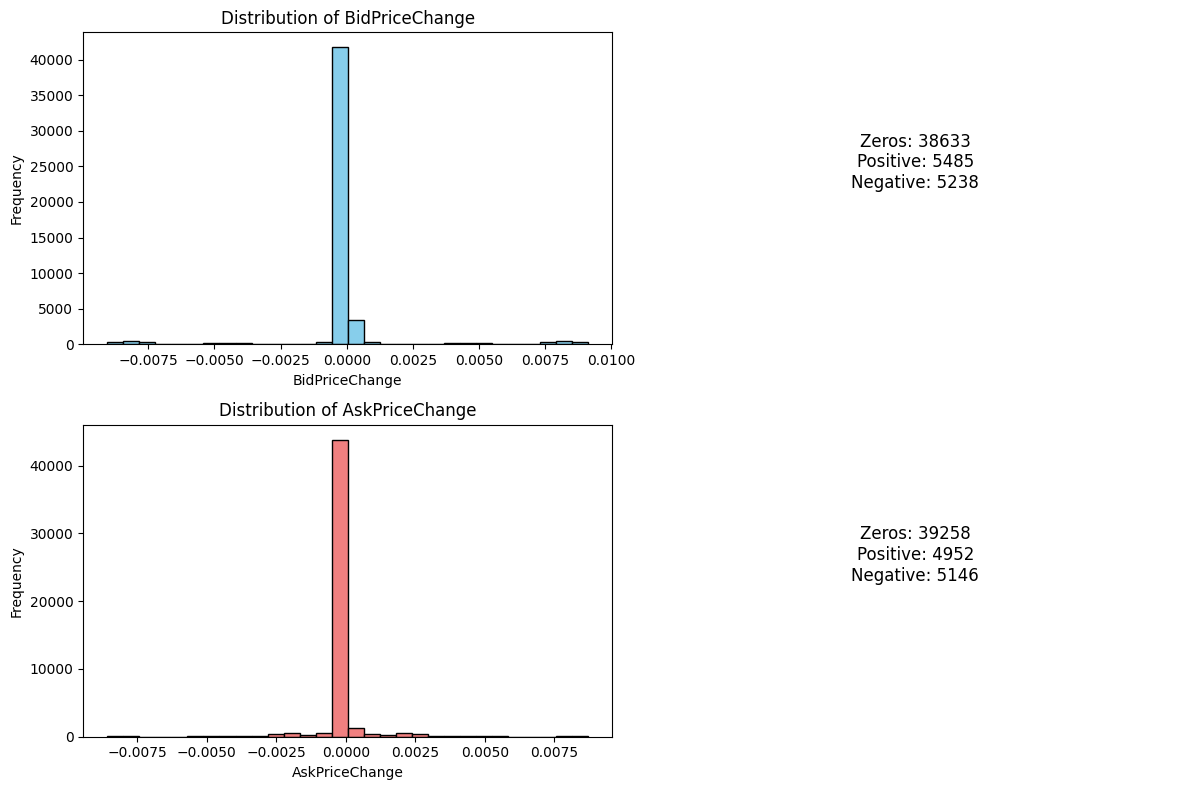

In [191]:
columns = ['BidPriceChange','AskPriceChange']
plot_histograms_and_stats(filtered_factors, columns)


In [150]:
training_start_time, training_end_time = "2021-11-05 18:59:54.93", "2021-11-05 19:45:54.0"
prediction_start_time, prediction_end_time = "2021-11-05 19:45:54.0", "2021-11-05 19:59:54.0"

def get_train_test_windows(df, train_start_time, train_end_time, test_start_time, test_end_time):
    training_window_df = None
    test_window_df = None
    
    try:
        training_start_time = pd.to_datetime(train_start_time)
        training_end_time = pd.to_datetime(train_end_time)
        prediction_start_time = pd.to_datetime(test_start_time)
        prediction_end_time = pd.to_datetime(test_end_time)

        # Check if the desired training window is inside the dataset's time range
        if pd.to_datetime(df['COLLECTION_TIME'].min()) < training_start_time and pd.to_datetime(df['COLLECTION_TIME'].max()) > training_end_time:
            training_window_df = filter_time_window(df, training_start_time, training_end_time)
            training_window_df.reset_index(drop=True, inplace=True)

        if pd.to_datetime(df['COLLECTION_TIME'].min()) < prediction_start_time and pd.to_datetime(df['COLLECTION_TIME'].max()) > prediction_end_time:
            test_window_df = filter_time_window(df, prediction_start_time, prediction_end_time)
            test_window_df.reset_index(drop=True, inplace=True)

        if len(training_window_df) == 0  or len(test_window_df) == 0:
            print("Desired training or prediction window not inside dataset's time range.")
        else:
            return training_window_df, test_window_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

train_df, test_df = get_train_test_windows(factors, training_start_time, training_end_time, prediction_start_time, prediction_end_time)

feature_cols = ['OFI', 'RSI', 'MACD','VWAP', 'Volatility', 'EMA']
label_cols = ['BID_PRICE_1']


train_features = train_df[feature_cols]
train_labels = train_df[label_cols]
test_features = test_df[feature_cols]
test_labels = test_df[label_cols]

# # Shift labels up by 1 row because we are trying to predict next row's price
# train_labels = train_labels.shift(-1)
# test_labels = test_labels.shift(-1)
# # Remove the last row in training features
# train_features = train_features[:-1]
# train_labels = train_labels[:-1]
# test_features = test_features[:-1]
# test_labels = test_labels[:-1]

print(f"Training features shape: {train_features.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training features shape: (35506, 6)
Training labels shape: (35506, 1)
Test features shape: (13844, 6)
Test labels shape: (13844, 1)


In [151]:
import numpy as np

# Check if X_train contains NaN values
contains_nan_X = np.isnan(train_features).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(train_labels).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')


# Check if X_train contains NaN values
contains_nan_X = np.isnan(test_features).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(test_labels).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')

X_train contains NaN values: OFI           False
RSI            True
MACD          False
VWAP          False
Volatility    False
EMA           False
dtype: bool
y_train contains NaN values: BID_PRICE_1    False
dtype: bool
X_train contains NaN values: OFI           False
RSI            True
MACD          False
VWAP          False
Volatility    False
EMA           False
dtype: bool
y_train contains NaN values: BID_PRICE_1    False
dtype: bool


In [152]:

# Identify and remove rows with NaN values from both X_train and y_train
nan_indices1 = np.isnan(train_features).any(axis=1)

train_features_c = train_features[~nan_indices1]
train_labels_c = train_labels[~nan_indices1]

nan_indices2 = np.isnan(test_features).any(axis=1)
test_features_c = test_features[~nan_indices2]
test_labels_c= test_labels[~nan_indices2]



In [153]:
train_features = train_features_c
train_labels = train_labels_c

test_features = test_features_c
test_labels = test_labels_c

print(f"Training features shape: {train_features.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training features shape: (35410, 6)
Training labels shape: (35410, 1)
Test features shape: (13770, 6)
Test labels shape: (13770, 1)


In [154]:
import numpy as np

# Check if X_train contains NaN values
contains_nan_X = np.isnan(train_features).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(train_labels).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')


# Check if X_train contains NaN values
contains_nan_X = np.isnan(test_features).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(test_labels).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')

X_train contains NaN values: OFI           False
RSI           False
MACD          False
VWAP          False
Volatility    False
EMA           False
dtype: bool
y_train contains NaN values: BID_PRICE_1    False
dtype: bool
X_train contains NaN values: OFI           False
RSI           False
MACD          False
VWAP          False
Volatility    False
EMA           False
dtype: bool
y_train contains NaN values: BID_PRICE_1    False
dtype: bool


In [155]:
train_features.head()

OFI        RSI      MACD        VWAP  Volatility         EMA
0  0.703704  49.888999  0.013898  150.600119    0.105362  150.599775
1  0.744557  50.250352  0.008625  150.610291    0.105288  150.600749
2  0.701188  50.250352  0.004395  150.610291    0.105213  150.601630
3  0.802025  50.250352  0.001031  150.610074    0.105137  150.602427
4  0.701188  50.250352 -0.001616  150.610074    0.105061  150.603148

In [156]:
train_labels.head(6)

y_tr = train_labels

In [157]:
sc_labels = MinMaxScaler(feature_range=(0, 1))

train_labels_scaled = sc_labels.fit_transform(train_labels)

train_labels_scaled[:5]

array([[0.4084507 ],
       [0.41549296],
       [0.41549296],
       [0.41549296],
       [0.41549296]])

In [158]:
test_df.head()

COLLECTION_TIME  BID_PRICE_1  ASK_PRICE_1  BidPriceChange  \
0 2021-11-05 19:45:55.522081024       151.26       151.29             0.0   
1 2021-11-05 19:45:55.524529920       151.26       151.29             0.0   
2 2021-11-05 19:45:55.654966016       151.26       151.29             0.0   
3 2021-11-05 19:45:55.842571008       151.26       151.27             0.0   
4 2021-11-05 19:45:56.096688896       151.26       151.27             0.0   

   AskPriceChange  SpreadChange  BidPriceDir  AskPriceDir       OFI  \
0        0.000000      2.000000            0            1  0.644269   
1        0.000000      0.000000            0            0  0.702970   
2       -0.000132      0.000000            0            0  0.644269   
3        0.000000     -0.666667            0            0  0.590822   
4        0.000000      0.000000            0            0  0.040359   

         RSI      MACD        VWAP  Volatility         EMA  
0  49.959952  0.003856  151.260149    0.082446  151.252417  
1  49.959952 -0.002231  151.260120    0.081412  151.253139  
2  49.959952 -0.006975  151.260149    0.080351  151.253792  
3  49.959548 -0.011410  151.262000    0.080351  151.254384  
4  49.959548 -0.014755  151.265000    0.080351  151.254918

In [159]:
test_features.head(6)

OFI        RSI      MACD        VWAP  Volatility         EMA
0  0.644269  49.959952  0.003856  151.260149    0.082446  151.252417
1  0.702970  49.959952 -0.002231  151.260120    0.081412  151.253139
2  0.644269  49.959952 -0.006975  151.260149    0.080351  151.253792
3  0.590822  49.959548 -0.011410  151.262000    0.080351  151.254384
4  0.040359  49.959548 -0.014755  151.265000    0.080351  151.254918
5  0.590822  49.959548 -0.017207  151.262000    0.080351  151.255402

In [160]:
test_labels.head(6)

y_te = test_labels



In [161]:
# def create_sequences(features, labels, sequence_length):
#     sc = MinMaxScaler(feature_range=(0, 1))
#     # scaler returns numpy array
#     features_np = sc.fit_transform(features)
#     labels_np = sc.fit_transform(labels).reshape(-1, 1)
#     feature_sequences = []
#     label_sequences = []
    
#     for i in range(len(features_np) - sequence_length):
#         feature_sequences.append(features_np[i:i+sequence_length])
#         label_sequences.append(labels_np[i + sequence_length])
    
#     # return feature_sequences, label_sequences
#     return torch.tensor(feature_sequences, dtype=torch.float32), torch.tensor(label_sequences, dtype=torch.float32)

def create_sequences1(features_df, labels_df, sequence_length):
    sc_features = MinMaxScaler(feature_range=(0, 1))
    sc_labels = MinMaxScaler(feature_range=(0, 1))
    
    # Assuming features_df and labels_df are pandas DataFrames
    features_np = sc_features.fit_transform(features_df)
    labels_np = sc_labels.fit_transform(labels_df)

    # features_np = features_df
    # labels_np = labels_df

    feature_sequences = []
    label_sequences = []

    for i in range(len(features_df) - sequence_length):
        # Append sequences of length 'sequence_length' to feature_sequences
        feature_sequences.append(features_np[i:i+sequence_length])
        # Append the next label (after the end of the current sequence) to label_sequences
        label_sequences.append(labels_np[i + sequence_length])

    return np.array(feature_sequences), np.array(label_sequences)
    
    # for i in range(len(features_df) - sequence_length):
    #     # Append sequences of length 'sequence_length' to feature_sequences
    #     feature_sequences.append(features_np[i:i+sequence_length])
    #     # Append the next label (after the end of the current sequence) to label_sequences
    #     label_sequences.append(labels_np[i + sequence_length])

    # return np.array(feature_sequences), np.array(label_sequences)
    # return torch.tensor(feature_sequences, dtype=torch.float32), torch.tensor(label_sequences, dtype=torch.float32)

sequence_length = 10
X_train, y_train = create_sequences1(train_features, train_labels, sequence_length)
X_test, y_test = create_sequences1(test_features, test_labels, sequence_length)

# X_train, y_train = create_sequences1(train_features, train_labels, sequence_length)
# X_test, y_test = create_sequences1(test_features, test_labels, sequence_length)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(35400, 10, 6)
(35400, 1)
(13760, 10, 6)
(13760, 1)


In [162]:
X_train[0]

array([[0.85402377, 0.49888999, 0.55678131, 0.19260022, 0.20957509,
        0.40998008],
       [0.87470735, 0.50250352, 0.54349255, 0.19673818, 0.20942786,
        0.41066963],
       [0.85275034, 0.50250352, 0.53283343, 0.19673818, 0.20927928,
        0.4112935 ],
       [0.90380224, 0.50250352, 0.52435604, 0.19664997, 0.20912935,
        0.41185795],
       [0.85275034, 0.50250352, 0.5176846 , 0.19664997, 0.20897807,
        0.41236865],
       [0.8236573 , 0.50250352, 0.51250411, 0.19664997, 0.20882543,
        0.41283071],
       [0.68472454, 0.33718598, 0.57690034, 0.19801617, 0.24975364,
        0.41324877],
       [0.6870706 , 0.49705082, 0.55938039, 0.19824689, 0.24914789,
        0.41362701],
       [0.45285966, 0.49705082, 0.54522518, 0.20068768, 0.24853125,
        0.41396922],
       [0.53000281, 0.49705082, 0.53386748, 0.2000635 , 0.24790362,
        0.41427885]])

In [163]:
y_train[17]

array([0.28873239])

We can verify that the tensors have been formed in proper order by checking the 28th row in the y_label_df and the 17th element in the y_train tensor.

In [164]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [165]:
#!pip install keras
#!pip install tensorflow


In [166]:
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dropout
# from keras.layers import Dense
# from keras.layers import TimeDistributed

# import tensorflow as tf
# import keras
# from keras import optimizers
# from keras.callbacks import History
# from keras.models import Model
# from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
# import numpy as np
# #tf.random.set_seed(20)
# np.random.seed(10)

# lstm_input = Input(shape=(10, 3), name='lstm_input')
# inputs = LSTM(150, name='first_layer')(lstm_input)
# inputs = Dense(1, name='dense_layer')(inputs)
# output = Activation('linear', name='output')(inputs)
# model = Model(inputs=lstm_input, outputs=output)
# adam = optimizers.Adam()
# model.compile(optimizer=adam, loss='mse')
# model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)



In [167]:
import numpy as np

# Check if X_train contains NaN values
contains_nan_X = np.isnan(X_train).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(y_train).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')


# Check if X_train contains NaN values
contains_nan_X = np.isnan(X_test).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(y_test).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')


X_train contains NaN values: False
y_train contains NaN values: False
X_train contains NaN values: False
y_train contains NaN values: False


In [168]:
# import torch
# import torch.nn as nn
# import numpy as np

# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
        
#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])  # we only want the last time step
#         return out

# # Initialize constants and the model
# input_dim = 3
# hidden_dim = 8
# output_dim = 1

# model = LSTMModel(input_dim, hidden_dim, output_dim)
# criterion = nn.MSELoss()  # Mean Squared Error Loss
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# num_epochs = 300
# num_predictions_to_print = 5  # Number of predictions to print per epoch

# for epoch in range(num_epochs):
#     # Convert NumPy arrays to PyTorch tensors
#     X_tensor = torch.from_numpy(X_train).float()
#     y_tensor = torch.from_numpy(y_train).float()

#     # Forward pass
#     outputs = model(X_tensor)
#     loss = criterion(outputs, y_tensor)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     # Convert the tensor predictions to a NumPy array
#     # and print the first few predictions
#     predictions = outputs.detach().numpy()
#     print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
#     print(f'First {num_predictions_to_print} Predictions:')
#     print(predictions[:num_predictions_to_print])
#     print("=" * 50)


# for epoch in range(num_epochs):
#     outputs = model(X_train)
#     loss = criterion(outputs, y_train)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     # Convert the tensor predictions to a numpy array
#     # and print the first few predictions
#     predictions = outputs.detach().numpy()
#     print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
#     print(f'First {num_predictions_to_print} Predictions:')
#     print(predictions[:num_predictions_to_print])
#     print("="*50)  # Add a separator for clarity


In [169]:
from torch.utils.data import TensorDataset, DataLoader

In [170]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [171]:

batch_size = 32  # You can adjust the batch size

# For training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# For testing data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [172]:
#len(y_test)
len(y_test_tensor)

13760

In [173]:


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # we only want the last time step
        return out


# Initialize constants and the model
input_dim = 6
hidden_dim = 16
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, output_dim,5,0)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

num_epochs = 40
num_predictions_to_print = 5  # Number of predictions to print per epoch



for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Update learning rate
    scheduler.step()

    # After each epoch, evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss = 0
        for features, labels in test_loader:
            test_outputs = model(features)
            total_loss += criterion(test_outputs, labels).item()
        avg_loss = total_loss / len(test_loader)
        print(f'Epoch {epoch}/{num_epochs}, Training Loss: {loss.item()}, Test Loss: {avg_loss}')

    # Convert the tensor predictions to a NumPy array
    # and print the first few predictions
    predictions = outputs.detach().numpy()
    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
    print(f'First {num_predictions_to_print} Predictions:')
    print(predictions[:num_predictions_to_print])
    print("=" * 50)

    
    # After each epoch, you can evaluate on a validation set if you have one


Epoch 0/40, Training Loss: 0.003468270879238844, Test Loss: 0.06154108686938809
Epoch 0/40, Loss: 0.003468270879238844
First 5 Predictions:
[[0.463997  ]
 [0.7085992 ]
 [0.51855433]
 [0.49065766]
 [0.27474788]]
Epoch 1/40, Training Loss: 0.012050003744661808, Test Loss: 0.06405417860846789
Epoch 1/40, Loss: 0.012050003744661808
First 5 Predictions:
[[0.54635715]
 [0.4218617 ]
 [0.10545129]
 [0.26339334]
 [0.29400977]]


KeyboardInterrupt: 

In [ ]:


train_outputs = model(X_train_tensor)

test_outputs = model(X_test_tensor)


In [ ]:
# Concatenate all predictions and convert to NumPy array
tr_predictions = train_outputs.detach().numpy()

tr_predictions = sc_labels.inverse_transform(tr_predictions)

tr_predictions.round(2)

In [ ]:

# Concatenate all predictions and convert to NumPy array
test_predictions = test_outputs.detach().numpy()

test_predictions = sc_labels.inverse_transform(test_predictions)

test_predictions.round(2)

In [ ]:
y_tr = y_tr.values

y_tr

In [ ]:
y_te = y_te.values

y_te

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

import matplotlib.pyplot as plt

# Convert labels to the original scale if they are also scaled
# If they are already in the original scale, you can skip this step

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_tr, label='Actual Labels', color='blue')
plt.plot(tr_predictions, label='Predicted Labels', color='red')
plt.title('Comparison of Actual and Predicted Values Train data')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:


# Convert labels to the original scale if they are also scaled
# If they are already in the original scale, you can skip this step

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_te, label='Actual Labels', color='blue')
plt.plot(test_predictions, label='Predicted Labels', color='red')
plt.title('Comparison of Actual and Predicted Values Test data')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_tr, label='Actual Labels', color='blue')
plt.plot(tr_predictions, label='Predicted Labels', color='red')
plt.title('Comparison of Actual and Predicted Values Train data')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()

# Set the x-axis limits (xlim) from xmin to xmax
xmin = 1500  # Replace with your desired minimum x-value
xmax = 1600  # Replace with your desired maximum x-value
plt.xlim(xmin, xmax)

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_te, label='Actual Labels', color='blue')
plt.plot(test_predictions, label='Predicted Labels', color='red')
plt.title('Comparison of Actual and Predicted Values Test data')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()

# Set the x-axis limits (xlim) from xmin to xmax
xmin = 5000  # Replace with your desired minimum x-value
xmax = 5100  # Replace with your desired maximum x-value
plt.xlim(xmin, xmax)

plt.show()

In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# import time

# # Define constants
# input_dim = 4  # Change to 4 because of data shape
# hidden_dim = 32
# num_layers = 2
# output_dim = 1
# num_epochs = 100

# # Define the LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(LSTM, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
        
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
#         out = self.fc(out[:, -1, :]) 
#         return out

# # Initialize the model, criterion, and optimizer
# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# criterion = torch.nn.MSELoss(reduction='mean')  # Mean Squared Error Loss
# optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# # Training loop
# hist = np.zeros(num_epochs)
# start_time = time_module.time()


# for t in range(num_epochs):
#     y_train_pred = model(X_train)
    
#     loss = criterion(y_train_pred, y_train)
#     rmse = torch.sqrt(loss)  # Compute the Root Mean Square Error (RMSE)
    
#     print("Epoch ", t, "MSE: ", loss.item(), "RMSE: ", rmse.item())
    
#     hist[t] = loss.item()
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()
    
# training_time = time_module.time() - start_time
# print("Training time: {}".format(training_time))


In [ ]:
def load_dataframe_from_gz(gz_file_path):
    # Decompress the .gz file and read its content
    with gzip.open(gz_file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

In [ ]:
# Define the paths to your files
file_paths = [
    "sample_data/20211103_book_updates.csv.gz",
    "sample_data/20211104_book_updates.csv.gz",
    "sample_data/20211105_book_updates.csv.gz"
]

# Initialize an empty DataFrame
deep = pd.DataFrame()

# Loop through each file and append its contents to the DataFrame
for file_path in file_paths:
    temp_df = load_dataframe_from_gz(file_path)
    deep = pd.concat([deep, temp_df], ignore_index=True)

In [ ]:
deep

In [ ]:
book_updates_df = deep

book_updates_df.head()

In [ ]:

book_updates_df["mid_price"] = (book_updates_df["ASK_PRICE_1"]+ book_updates_df["BID_PRICE_1"])/2

book_updates_df.head()

In [ ]:
aapl_book_updates_df = book_updates_df[book_updates_df["SYMBOL"]=="AAPL"]

aapl_book_updates_df.head()



In [ ]:
len(aapl_book_updates_df)

In [ ]:
aapl_book_updates_df = aapl_book_updates_df.dropna()

In [ ]:
len(aapl_book_updates_df)

In [ ]:

# Converting the COLLECTION_TIME to datetime and setting it as the index
df = aapl_book_updates_df.copy()
df['COLLECTION_TIME'] = pd.to_datetime(df['COLLECTION_TIME'])
df.set_index('COLLECTION_TIME', inplace=True)

# Adjusting the aggregation dictionary for OHLC
ohlc_dict = {#'BID_PRICE_1': ['first', 'max', 'min', 'last'],
    #'ASK_PRICE_1': ['first', 'max', 'min', 'last'],
    'mid_price':['first', 'max', 'min', 'last'],
    'BID_SIZE_1': ['sum'],
    'ASK_SIZE_1': ['sum'],
    'BID_SIZE_2': ['sum'],
    'ASK_SIZE_2': ['sum'],
    'BID_SIZE_3': ['sum'],
    'ASK_SIZE_3': ['sum']}

# Resample and aggregate for different time frames
one_sec_candles = df.resample('1S').agg(ohlc_dict)
five_sec_candles = df.resample('5S').agg(ohlc_dict)
one_min_candles = df.resample('1T').agg(ohlc_dict)


# Show the first few rows of each aggregated DataFrame
one_sec_candles.head(), one_min_candles.head(), five_sec_candles.head()



In [ ]:
# Flatten the MultiIndex columns
one_sec_candles.columns = ['_'.join(col).strip() for col in one_sec_candles.columns.values]

# Example renaming (you should adjust this according to your needs)
# This is a simple renaming for demonstration; adjust it to match your OHLC logic
new_column_names = {
    # 'BID_PRICE_1_first': 'BID_PRICE_1_open',
    # 'BID_PRICE_1_max': 'BID_PRICE_1_high',
    # 'BID_PRICE_1_min': 'BID_PRICE_1_low',
    # 'BID_PRICE_1_last': 'BID_PRICE_1_close',

    # 'ASK_PRICE_1_first': 'ASK_PRICE_1_open',
    # 'ASK_PRICE_1_max': 'ASK_PRICE_1_high',
    # 'ASK_PRICE_1_min': 'ASK_PRICE_1_low',
    # 'ASK_PRICE_1_last': 'ASK_PRICE_1_close',

    'mid_price_first': 'MID_PRICE_open',
    'mid_price_max': 'MID_PRICE_high',
    'mid_price_min': 'MID_PRICE_low',
    'mid_price_last': 'MID_PRICE_close',

    'BID_SIZE_1_sum': 'BID_SIZE_1_total',
    
    'ASK_SIZE_1_sum': 'ASK_SIZE_1_total',

    'BID_SIZE_2_sum': 'BID_SIZE_2_total',
    
    'ASK_SIZE_2_sum': 'ASK_SIZE_2_total',

    'BID_SIZE_3_sum': 'BID_SIZE_3_total',
    
    'ASK_SIZE_3_sum': 'ASK_SIZE_3_total'
}

one_sec_candles.rename(columns=new_column_names, inplace=True)

# Now, one_sec_candles is a DataFrame with single-level column headers
one_sec_candles.head()



In [ ]:
print(len(one_sec_candles))
one_sec_candles.columns

In [ ]:
one_sec_candles = one_sec_candles.dropna()

In [ ]:
len(one_sec_candles)

In [ ]:
def calculate_ofi(df, bid_size_cols, ask_size_cols):
    total_bid_volume = df[bid_size_cols].sum(axis=1)
    total_ask_volume = df[ask_size_cols].sum(axis=1)
    ofi = (total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume)
    return ofi

def calculate_rsi(df, column='MID_PRICE_close', periods=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_volatility(df, column='MID_PRICE_close', periods=20):
    return df[column].pct_change().rolling(window=periods).std()

def calculate_macd(df, column='MID_PRICE_close', slow=26, fast=12, signal=9):
    ema_fast = df[column].ewm(span=fast, adjust=False).mean()
    ema_slow = df[column].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_ema(df, column='MID_PRICE_close', periods=20):
    return df[column].ewm(span=periods, adjust=False).mean()

In [ ]:
ask_size_cols, bid_size_cols = ['ASK_SIZE_1_total', 'ASK_SIZE_2_total', 'ASK_SIZE_3_total'], ['BID_SIZE_1_total', 'BID_SIZE_2_total', 'BID_SIZE_3_total']

data = one_sec_candles.copy()

one_sec_candles['OFI'] = calculate_ofi(data, bid_size_cols, ask_size_cols)
one_sec_candles['RSI'] = calculate_rsi(data)
one_sec_candles['MACD'],one_sec_candles["SIGNAL_LINE"] =calculate_macd(data)
one_sec_candles["EMA"] = calculate_ema(data)
one_sec_candles["Volatility"] = calculate_volatility(data)


In [ ]:
# Now, one_sec_candles is a DataFrame with single-level column headers
one_sec_candles.head()

In [ ]:
print(len(one_sec_candles))

print(one_sec_candles.isna().sum())


In [ ]:
one_sec_candles.columns

In [ ]:
columns = ['MID_PRICE_close', 'OFI', 'RSI', 'MACD', 'Volatility', 'SIGNAL_LINE']

df = one_sec_candles[columns]

df= df.copy()

df["Y1"] = df['MID_PRICE_close'].diff()

df["Y2"] = df['Y1'].shift(-1)

# Corrected code for setting values
df["Y1"].iloc[0] = 0
df["Y2"].iloc[-1] = 0


print((df["Y1"]==0).sum())

print(len(df))

df


In [ ]:
df = df.dropna()

df

In [ ]:
# Define the window size (number of observations)
window_size = 50  # Adjust as needed

# Function to perform Min-Max scaling within a window
def min_max_scale(x):
    min_val = x.min()
    max_val = x.max()
    range_val = max_val - min_val
    if range_val == 0:
        return 0  # Avoid division by zero
    else:
        return (x - min_val) / range_val

# Define a function to standardize data to range -3 to 3
def standardize(series):
    normalized = (series - series.mean()) / series.std()
    # Scale to the range -3 to 3
    standardized = 3 * normalized / normalized.max()
    return standardized

# Apply rolling window and then apply the Min-Max scaling function
df['MID_PRICE_close_scaled'] = df['MID_PRICE_close'].rolling(window=window_size).apply(lambda x: min_max_scale(x.iloc[-1]), raw=False)
#df['EMA_scaled'] = df['EMA'].rolling(window=window_size).apply(lambda x: min_max_scale(x.iloc[-1]), raw=False)
df['RSI_scaled'] = df['RSI'].rolling(window=window_size).apply(lambda x: standardize(x.iloc[-1]), raw=False)

rolling_windows = df['RSI'].rolling(window=window_size)
# Apply standardization to each rolling window
#standardized_data = rolling_windows.apply(standardize)

#df['RSI_new'] = df['RSI'].rolling(window=window_size).apply(lambda x: standardize(x.iloc[-1]), raw=False)


# The result will be NaN for the first few rows where the window is not full
print(df)

In [ ]:
(df["Y2"]!=0).sum()

In [ ]:
# Define the window size (number of observations)
window_size = 100  # You can adjust this to your desired window size

# Function to calculate z-score for each element in the window
def z_score(x):
    if x.std() == 0:
        return 0  # Avoid division by zero
    else:
        return (x - x.mean()) / x.std()

# Apply rolling window and then apply the z-score function element-wise
df['MID_PRICE_close_z'] = df['MID_PRICE_close'].rolling(window=window_size).apply(lambda x: z_score(x.iloc[-1]), raw=False)
#df['EMA_z'] = df['EMA'].rolling(window=window_size).apply(lambda x: z_score(x.iloc[-1]), raw=False)

# The result will be NaN for the first few rows where the window is not full
print(df)
print((df["MID_PRICE_close_z"]!=0).sum())

In [ ]:


sc_labels = MinMaxScaler(feature_range=(0, 1))

# Reshape the data to a 2D array
df["Y2_scaled"] = sc_labels.fit_transform(df[["Y2"]])

print((df["Y2"] != 0).sum())

In [ ]:
print(len(df))
print((df["EMA_scaled"]==0).sum())

df= df.dropna()

print(len(df))

In [ ]:
df = df.dropna()

In [ ]:
df2 = df.reset_index()
#print(df2)


# Assuming df2 is already defined and reset_index() has been applied
div = int(0.75 * len(df2))

train_start = df2["COLLECTION_TIME"].iloc[0]  # First element
train_end = df2["COLLECTION_TIME"].iloc[div]

test_start = df2["COLLECTION_TIME"].iloc[div + 1]
test_end = df2["COLLECTION_TIME"].iloc[-1]  # Last element

print(train_start)
print(train_end)
print(test_start)
print(test_end)


In [ ]:
df2.columns

In [ ]:

def filter_time_window(df1, start_time, end_time):
    df = df1.copy()

    # Convert 'COLLECTION_TIME' column to datetime.time objects if it's not already
    if not isinstance(df['COLLECTION_TIME'].iloc[0], time):
        df['COLLECTION_TIME'] = pd.to_datetime(df['COLLECTION_TIME'])

    # Create the mask to filter the time window
    mask = (df['COLLECTION_TIME'] >= start_time) & (df['COLLECTION_TIME'] < end_time)
    return df[mask]


In [ ]:
training_start_time, training_end_time = train_start, train_end
prediction_start_time, prediction_end_time = test_start, test_end

def get_train_test_windows(df, train_start_time, train_end_time, test_start_time, test_end_time):
    training_window_df = None
    test_window_df = None
    
    try:
        training_start_time = pd.to_datetime(train_start_time)
        training_end_time = pd.to_datetime(train_end_time)
        prediction_start_time = pd.to_datetime(test_start_time)
        prediction_end_time = pd.to_datetime(test_end_time)

        # Check if the desired training window is inside the dataset's time range
        if pd.to_datetime(df['COLLECTION_TIME'].min()) <= training_start_time and pd.to_datetime(df['COLLECTION_TIME'].max()) >= training_end_time:
            training_window_df = filter_time_window(df, training_start_time, training_end_time)
            training_window_df.reset_index(drop=True, inplace=True)

        if pd.to_datetime(df['COLLECTION_TIME'].min()) <= prediction_start_time and pd.to_datetime(df['COLLECTION_TIME'].max()) >= prediction_end_time:
            test_window_df = filter_time_window(df, prediction_start_time, prediction_end_time)
            test_window_df.reset_index(drop=True, inplace=True)

        if len(training_window_df) == 0  or len(test_window_df) == 0:
            print("Desired training or prediction window not inside dataset's time range.")
        else:
            return training_window_df, test_window_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None

train_df, test_df = get_train_test_windows(df2, training_start_time, training_end_time, prediction_start_time, prediction_end_time)

feature_cols = ['OFI', 'SIGNAL_LINE', 'MACD', 'Volatility']
label_cols = ['Y2']




In [ ]:
train_features = train_df[feature_cols]
train_labels = train_df[label_cols]
test_features = test_df[feature_cols]
test_labels = test_df[label_cols]

# # Shift labels up by 1 row because we are trying to predict next row's price
# train_labels = train_labels.shift(-1)
# test_labels = test_labels.shift(-1)
# # Remove the last row in training features
# train_features = train_features[:-1]
# train_labels = train_labels[:-1]
# test_features = test_features[:-1]
# test_labels = test_labels[:-1]

print(f"Training features shape: {train_features.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

In [63]:
def create_sequences1(features_df, labels_df, sequence_length):
    # sc_features = MinMaxScaler(feature_range=(0, 1))
    # sc_labels = MinMaxScaler(feature_range=(0, 1))
    
    # # Assuming features_df and labels_df are pandas DataFrames
    # features_np = sc_features.fit_transform(features_df)
    # labels_np = sc_labels.fit_transform(labels_df)

    # feature_sequences = []
    # label_sequences = []

    # for i in range(len(features_df) - sequence_length):
    #     # Append sequences of length 'sequence_length' to feature_sequences
    #     feature_sequences.append(features_np[i:i+sequence_length])
    #     # Append the next label (after the end of the current sequence) to label_sequences
    #     label_sequences.append(labels_np[i + sequence_length])

    
    features_np = features_df
    labels_np = labels_df

    feature_sequences = []
    label_sequences = []

    for i in range(len(features_df) - sequence_length):
        # Append sequences of length 'sequence_length' to feature_sequences
        feature_sequences.append(features_np.iloc[i:i+sequence_length])
        # Append the next label (after the end of the current sequence) to label_sequences
        label_sequences.append(labels_np.iloc[i + sequence_length])

    return np.array(feature_sequences), np.array(label_sequences)#, sc_features, sc_labels
    

sequence_length = 5
X_train, y_train = create_sequences1(train_features, train_labels, sequence_length)
X_test, y_test = create_sequences1(test_features, test_labels, sequence_length)

# X_train, y_train, sc_features_train, sc_labels_train = create_sequences1(train_features, train_labels, sequence_length)
# X_test, y_test, sc_features_test, sc_labels_test = create_sequences1(test_features, test_labels, sequence_length)

# X_train, y_train = create_sequences1(train_features, train_labels, sequence_length)
# X_test, y_test = create_sequences1(test_features, test_labels, sequence_length)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(47422, 5, 4)
(47422, 1)
(15802, 5, 4)
(15802, 1)


In [ ]:


X_train, y_train = np.array(train_features), np.array(train_labels)
X_test, y_test = np.array(test_features), np.array(test_labels)

In [ ]:
X_train

In [ ]:
import numpy as np

# Check if X_train contains NaN values
contains_nan_X = np.isnan(X_train).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(y_train).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')


# Check if X_train contains NaN values
contains_nan_X = np.isnan(X_test).any()

# Check if y_train contains NaN values
contains_nan_y = np.isnan(y_test).any()

print(f'X_train contains NaN values: {contains_nan_X}')
print(f'y_train contains NaN values: {contains_nan_y}')

In [64]:


from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
X_train

In [ ]:
a = X_train_tensor.unsqueeze(0)
a.size()
# for f,l in train_loader:
#     print(f.size())
#     print(l)
#     break

In [65]:


batch_size = 64  # You can adjust the batch size

# For training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

# For testing data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        # Batch normalization layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Optionally add a ReLU activation here if you find it beneficial
        #self.relu = nn.ReLU()

        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.batch_norm(out)  # Apply batch normalization to the last time step
        out = self.relu(out)
        out = self.fc(out)
        # out = self.relu(out)  # Uncomment if using ReLU
        # return out
        # out = self.fc(out[:, -1, :])  # we only want the last time step
        return out

# Constants initialization
input_dim = 4
hidden_dim = 15
output_dim = 1
num_layers = 3
learning_rate = 0.001
num_epochs = 90
num_predictions_to_print = 3

# Model, loss function, optimizer, and scheduler initialization
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout=0)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.1)



for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (features, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Update learning rate
    scheduler.step()

    # After each epoch, evaluate on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss = 0
        for features, labels in test_loader:
            test_outputs = model(features)
            total_loss += criterion(test_outputs, labels).item()
        avg_loss = total_loss / len(test_loader)
        print(f'Epoch {epoch}/{num_epochs}, Training Loss: {loss.item()}, Test Loss: {avg_loss}')

    # Convert the tensor predictions to a NumPy array
    # and print the first few predictions
    predictions = outputs.detach().numpy()
    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
    print(f'First {num_predictions_to_print} Predictions:')
    print(predictions[:num_predictions_to_print])
    print("=" * 50)

    
    # After each epoch, you can evaluate on a validation set if you have one

In [ ]:
torch.save(model.state_dict(), 'saved_models/model_NO_RSI_Y2_batch_norm_relu.pth')

In [ ]:
np.savetxt("saved_models/model_NO_RSI_Y2_batch_norm_relu_scaler_params.txt", np.vstack([scale, min_val]), delimiter=",")

In [ ]:
scale = sc_labels.scale_
min_val = sc_labels.min_

scale, min_val

#

In [131]:


model.load_state_dict(torch.load('saved_models/model_sig_NOrsi_batch_norm_relu.pth'))
model.eval()

RuntimeError: Error(s) in loading state_dict for LSTMModel:
	Unexpected key(s) in state_dict: "lstm.weight_ih_l3", "lstm.weight_hh_l3", "lstm.bias_ih_l3", "lstm.bias_hh_l3", "lstm.weight_ih_l4", "lstm.weight_hh_l4", "lstm.bias_ih_l4", "lstm.bias_hh_l4". 
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([200, 4]) from checkpoint, the shape in current model is torch.Size([60, 4]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([200, 50]) from checkpoint, the shape in current model is torch.Size([60, 15]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([200]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([200]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for lstm.weight_ih_l1: copying a param with shape torch.Size([200, 50]) from checkpoint, the shape in current model is torch.Size([60, 15]).
	size mismatch for lstm.weight_hh_l1: copying a param with shape torch.Size([200, 50]) from checkpoint, the shape in current model is torch.Size([60, 15]).
	size mismatch for lstm.bias_ih_l1: copying a param with shape torch.Size([200]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for lstm.bias_hh_l1: copying a param with shape torch.Size([200]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for lstm.weight_ih_l2: copying a param with shape torch.Size([200, 50]) from checkpoint, the shape in current model is torch.Size([60, 15]).
	size mismatch for lstm.weight_hh_l2: copying a param with shape torch.Size([200, 50]) from checkpoint, the shape in current model is torch.Size([60, 15]).
	size mismatch for lstm.bias_ih_l2: copying a param with shape torch.Size([200]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for lstm.bias_hh_l2: copying a param with shape torch.Size([200]) from checkpoint, the shape in current model is torch.Size([60]).
	size mismatch for batch_norm.weight: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([15]).
	size mismatch for batch_norm.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([15]).
	size mismatch for batch_norm.running_mean: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([15]).
	size mismatch for batch_norm.running_var: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([15]).
	size mismatch for fc.weight: copying a param with shape torch.Size([1, 50]) from checkpoint, the shape in current model is torch.Size([1, 15]).

In [69]:
train_outputs = model(X_train_tensor)

test_outputs = model(X_test_tensor)

In [70]:
tr_pred = train_outputs.detach().numpy()

print(tr_pred)

#tr_pred = sc_labels.inverse_transform(tr_pred)



te_pred = test_outputs.detach().numpy()

#te_pred = sc_labels.inverse_transform(te_pred)

print(te_pred)

[[-0.12281001]
 [-0.02104958]
 [ 0.03604595]
 ...
 [ 0.00719536]
 [ 0.00222075]
 [ 0.0032242 ]]
[[ 0.00140411]
 [-0.00304826]
 [-0.00024842]
 ...
 [-0.01171851]
 [ 0.00370646]
 [-0.00271654]]


In [ ]:
tr_pred

In [79]:
te_pred

array([[ 0.00140411],
       [-0.00304826],
       [-0.00024842],
       ...,
       [-0.01171851],
       [ 0.00370646],
       [-0.00271654]], dtype=float32)

In [ ]:
train_labels

In [ ]:
y_train

In [80]:
y_test

array([[-0.005],
       [-0.005],
       [ 0.11 ],
       ...,
       [ 0.3  ],
       [ 0.   ],
       [ 0.   ]])

In [81]:
y_tr = y_train
y_te = y_test

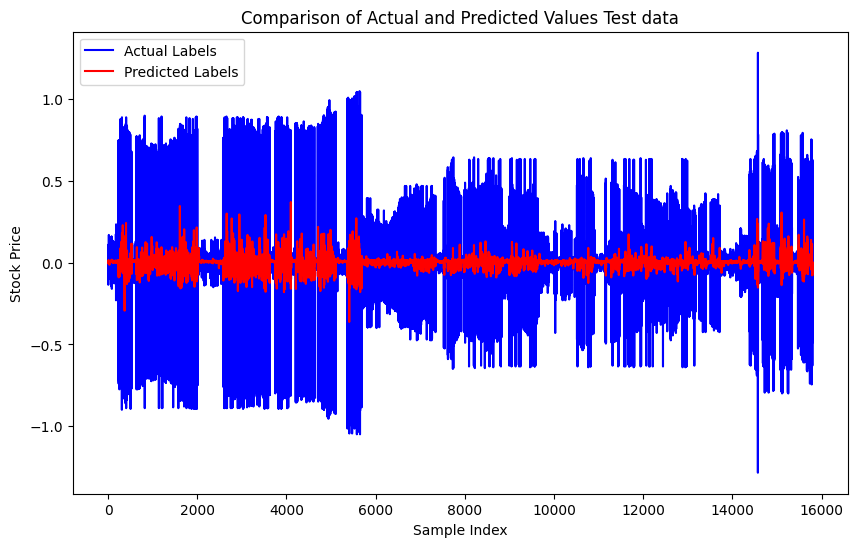

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(y_te, label='Actual Labels', color='blue')
plt.plot(te_pred, label='Predicted Labels', color='red')
plt.title('Comparison of Actual and Predicted Values Test data')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.savefig("saved_models/model_NO_RSI_Y2_batch_norm_relu_1.png")
plt.legend()
plt.show()



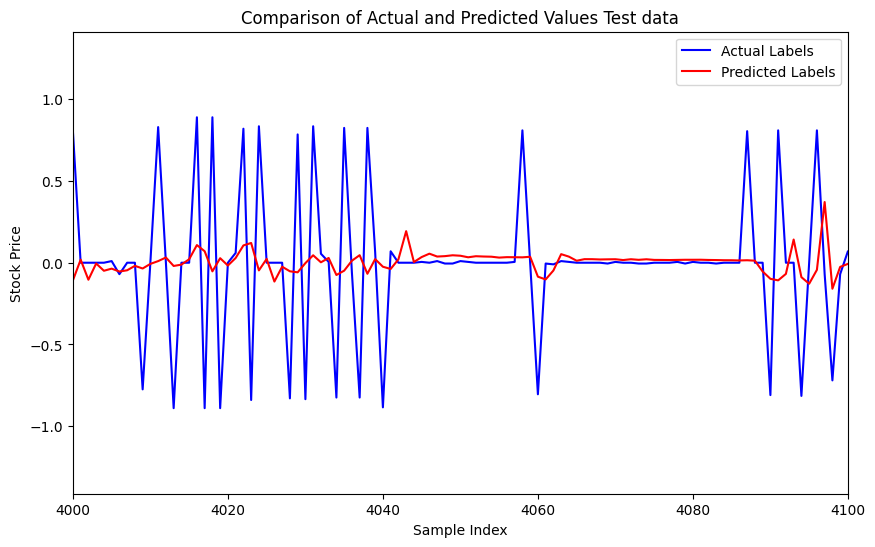

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(y_te, label='Actual Labels', color='blue')
plt.plot(te_pred, label='Predicted Labels', color='red')
plt.title('Comparison of Actual and Predicted Values Test data')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price')
plt.legend()

# Set the x-axis limits (xlim) from xmin to xmax
xmin = 4000  # Replace with your desired minimum x-value
xmax = 4100  # Replace with your desired maximum x-value
plt.xlim(xmin, xmax)

plt.savefig("saved_models/model_NO_RSI_Y2_batch_norm_relu_2.png")
plt.show()

In [114]:
y_test, te_pred


def mean_same_sign(array1, array2):
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Check for the same sign and calculate the mean of True values
    same_sign = np.sign(array1) == np.sign(array2)
    mean_true = np.mean(same_sign)
    return mean_true

mean_same_sign(y_test, te_pred)

0.3396405518288824

In [108]:
for i in range(len(te_pred)):
    

(array([[False],
        [False],
        [ True],
        ...,
        [ True],
        [False],
        [False]]),
 array([[ True],
        [False],
        [False],
        ...,
        [False],
        [ True],
        [False]]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [127]:


a = (y_train >= 0)
b = (tr_pred >= 0)



a,b

(array([[ True],
        [ True],
        [False],
        ...,
        [ True],
        [False],
        [False]]),
 array([[False],
        [False],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]))

In [128]:
c

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [129]:
c =  a==b

np.count_nonzero(c)/len(c)

0.6209776053308591

In [104]:
b

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
# Example usage:
# deep_path = "book_snapshots/20211105_book_updates.csv"
deep_path = "sample_data/20211105_book_updates.csv.gz"
deep = load_dataframe_from_gz(deep_path)

# trades_path = "book_snapshots/20211105_trades.csv"
trades_path = "sample_data/20211105_trades.csv.gz"
trades = load_dataframe_from_gz(trades_path)

In [ ]:
trades_df = trades
book_updates_df = deep

book_updates_df.head()

In [ ]:
trades_df['COLLECTION_TIME'] = pd.to_datetime(trades_df['COLLECTION_TIME'])
trades_df.set_index('COLLECTION_TIME', inplace=True)

# Adjusting the aggregation dictionary for OHLC
ohlc_dict = {'PRICE': ['first', 'max', 'min', 'last']}

# Resample and aggregate for different time frames
one_sec_candles = trades_df.resample('1S').agg(ohlc_dict)
one_min_candles = trades_df.resample('1T').agg(ohlc_dict)
five_min_candles = trades_df.resample('5T').agg(ohlc_dict)

# Renaming the columns to open, high, low, close for each DataFrame
one_sec_candles.columns = ['open', 'high', 'low', 'close']
one_min_candles.columns = ['open', 'high', 'low', 'close']
five_min_candles.columns = ['open', 'high', 'low', 'close']

# Show the first few rows of each aggregated DataFrame
one_sec_candles.head(), one_min_candles.head(), five_min_candles.head()

In [ ]:
# Splitting the DataFrame by 'SYMBOL' and processing each symbol's data individually

# Initialize dictionaries to store the results for each symbol
one_sec_candles_dict = {}
one_min_candles_dict = {}
five_min_candles_dict = {}

# Iterate over each group (symbol)
for symbol, group in aapl_book_updates_df.groupby('SYMBOL'):
    # Resample and aggregate for each time frame
    one_sec_resampled = group.resample('1S').agg({'PRICE': ['first', 'max', 'min', 'last']})
    one_min_resampled = group.resample('1T').agg({'PRICE': ['first', 'max', 'min', 'last']})
    five_min_resampled = group.resample('5T').agg({'PRICE': ['first', 'max', 'min', 'last']})
    
    # Rename columns
    one_sec_resampled.columns = ['open', 'high', 'low', 'close']
    one_min_resampled.columns = ['open', 'high', 'low', 'close']
    five_min_resampled.columns = ['open', 'high', 'low', 'close']
    
    # Store the results in the dictionaries
    one_sec_candles_dict[symbol] = one_sec_resampled
    one_min_candles_dict[symbol] = one_min_resampled
    five_min_candles_dict[symbol] = five_min_resampled

# Checking the results for one of the symbols
sample_symbol = list(one_sec_candles_dict.keys())[0]  # Just to view one sample symbol's data
one_sec_candles_dict[sample_symbol].head(), one_min_candles_dict[sample_symbol].head(), five_min_candles_dict[sample_symbol].head()


In [ ]:
book_updates_df["mid_price"] = (book_updates_df["ASK_PRICE_1"]+ book_updates_df["BID_PRICE_1"])/2

book_updates_df

aapl_book_updates_df = book_updates_df[book_updates_df["SYMBOL"]=="AAPL"]

aapl_book_updates_df

In [ ]:
aapl_book_updates_df.columns

In [ ]:
# Converting the COLLECTION_TIME to datetime and setting it as the index
df = aapl_book_updates_df.copy()
df['COLLECTION_TIME'] = pd.to_datetime(df['COLLECTION_TIME'])
df.set_index('COLLECTION_TIME', inplace=True)

# Adjusting the aggregation dictionary for OHLC
ohlc_dict = {'BID_PRICE_1': ['first', 'max', 'min', 'last'],
    'ASK_PRICE_1': ['first', 'max', 'min', 'last'],
    'mid_price':['first', 'max', 'min', 'last'],
    'BID_SIZE_1': ['sum'],
    'ASK_SIZE_1': ['sum'],
    'BID_SIZE_2': ['sum'],
    'ASK_SIZE_2': ['sum'],
    'BID_SIZE_3': ['sum'],
    'ASK_SIZE_3': ['sum']}

# Resample and aggregate for different time frames
one_sec_candles = df.resample('1S').agg(ohlc_dict)
one_min_candles = df.resample('1T').agg(ohlc_dict)
five_sec_candles = df.resample('5S').agg(ohlc_dict)

# Renaming the columns to open, high, low, close for each DataFrame
#one_sec_candles.columns = ['open', 'high', 'low', 'close']
#one_min_candles.columns = ['open', 'high', 'low', 'close']
#five_min_candles.columns = ['open', 'high', 'low', 'close']

# Show the first few rows of each aggregated DataFrame
one_sec_candles.head(), one_min_candles.head(), five_sec_candles.head()

In [ ]:
# Flatten the MultiIndex columns
one_sec_candles.columns = ['_'.join(col).strip() for col in one_sec_candles.columns.values]

# Example renaming (you should adjust this according to your needs)
# This is a simple renaming for demonstration; adjust it to match your OHLC logic
new_column_names = {
    'BID_PRICE_1_first': 'BID_PRICE_1_open',
    'BID_PRICE_1_max': 'BID_PRICE_1_high',
    'BID_PRICE_1_min': 'BID_PRICE_1_low',
    'BID_PRICE_1_last': 'BID_PRICE_1_close',

    'ASK_PRICE_1_first': 'ASK_PRICE_1_open',
    'ASK_PRICE_1_max': 'ASK_PRICE_1_high',
    'ASK_PRICE_1_min': 'ASK_PRICE_1_low',
    'ASK_PRICE_1_last': 'ASK_PRICE_1_close',

    'mid_price_first': 'MID_PRICE_open',
    'mid_price_max': 'MID_PRICE_high',
    'mid_price_min': 'MID_PRICE_low',
    'mid_price_last': 'MID_PRICE_close',

    'BID_SIZE_1_sum': 'BID_SIZE_1_total',
    
    'ASK_SIZE_1_sum': 'ASK_SIZE_1_total',

    'BID_SIZE_2_sum': 'BID_SIZE_2_total',
    
    'ASK_SIZE_2_sum': 'ASK_SIZE_2_total',

    'BID_SIZE_3_sum': 'BID_SIZE_3_total',
    
    'ASK_SIZE_3_sum': 'ASK_SIZE_3_total'
}

one_sec_candles.rename(columns=new_column_names, inplace=True)

# Now, one_sec_candles is a DataFrame with single-level column headers
one_sec_candles.head()

In [ ]:
# Processing the book updates data in a similar manner

# Initialize dictionaries to store the results for each symbol
one_sec_book_updates_dict = {}
one_min_book_updates_dict = {}
five_min_book_updates_dict = {}

# Aggregation dictionary for book updates

book_agg_dict = {
    'BID_PRICE_1': ['first', 'max', 'min', 'last','mean'],
    'ASK_PRICE_1': ['first', 'max', 'min', 'last','mean'],
    'BID_PRICE_2': ['first', 'max', 'min', 'last','mean'],
    'ASK_PRICE_2': ['first', 'max', 'min', 'last','mean'],
    'BID_PRICE_3': ['first', 'max', 'min', 'last','mean'],
    'ASK_PRICE_3': ['first', 'max', 'min', 'last','mean'],
    'BID_SIZE_1': ['sum'],
    'ASK_SIZE_1': ['sum'],
    'BID_SIZE_2': ['sum'],
    'ASK_SIZE_2': ['sum'],
    'BID_SIZE_3': ['sum'],
    'ASK_SIZE_3': ['sum']
}

# Iterate over each group (symbol) in the book updates DataFrame
for symbol, group in aapl_book_updates_df.groupby('SYMBOL'):
    # Convert COLLECTION_TIME to datetime and set it as index
    group['COLLECTION_TIME'] = pd.to_datetime(group['COLLECTION_TIME'])
    group.set_index('COLLECTION_TIME', inplace=True)

    # Resample and aggregate for each time frame
    one_sec_resampled = group.resample('1S').agg(book_agg_dict)
    one_min_resampled = group.resample('1T').agg(book_agg_dict)
    five_min_resampled = group.resample('5T').agg(book_agg_dict)

    # Calculate additional features on the resampled data
    #print(one_min_resampled)


    # Store the results in the dictionaries
    one_sec_book_updates_dict[symbol] = one_sec_resampled
    one_min_book_updates_dict[symbol] = one_min_resampled
    five_min_book_updates_dict[symbol] = five_min_resampled

# Checking the results for one of the symbols
#sample_symbol_book = list(one_sec_book_updates_dict.keys())[0]  # Just to view one sample symbol's data
one_sec_book_updates_dict["AAPL"].head()#, one_min_book_updates_dict[sample_symbol_book].head(), five_min_book_updates_dict[sample_symbol_book].head()


In [ ]:

bid_column, ask_column, ask_size_cols, bid_size_cols = 'BID_PRICE_1', 'ASK_PRICE_1', ['ASK_SIZE_1', 'ASK_SIZE_2', 'ASK_SIZE_3'], ['BID_SIZE_1', 'BID_SIZE_2', 'BID_SIZE_3']


def calculate_ofi(df, bid_size_cols, ask_size_cols):
    total_bid_volume = df[bid_size_cols].sum(axis=1)
    total_ask_volume = df[ask_size_cols].sum(axis=1)
    ofi = (total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume)
    return ofi



In [ ]:


df = one_sec_book_updates_dict["AAPL"]

df['OSI'] = calculate_ofi(df, bid_size_cols, ask_size_cols)

df

In [ ]:
def calculate_ofi(df, bid_size_cols, ask_size_cols):
    total_bid_volume = df[bid_size_cols].sum(axis=1)
    total_ask_volume = df[ask_size_cols].sum(axis=1)
    ofi = (total_bid_volume - total_ask_volume) / (total_bid_volume + total_ask_volume)
    return ofi

def calculate_rsi(df, column='PRICE', periods=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_volatility(df, column='PRICE', periods=20):
    return df[column].pct_change().rolling(window=periods).std()

def calculate_macd(df, column='PRICE', slow=26, fast=12, signal=9):
    ema_fast = df[column].ewm(span=fast, adjust=False).mean()
    ema_slow = df[column].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_ema(df, column='PRICE', periods=20):
    return df[column].ewm(span=periods, adjust=False).mean()


In [ ]:
bid_column, ask_column, ask_size_cols, bid_size_cols = 'BID_PRICE_1', 'ASK_PRICE_1', ['ASK_SIZE_1', 'ASK_SIZE_2', 'ASK_SIZE_3'], ['BID_SIZE_1', 'BID_SIZE_2', 'BID_SIZE_3']
    
    # Calculate the price change for BID and ASK separately
    df['BidPriceChange'] = df[bid_column].pct_change()    
    df['AskPriceChange'] = df[ask_column].pct_change()
    df['Spread'] = df[ask_column] - df[bid_column]
    df['SpreadChange'] = df['Spread'].pct_change()

    df['BidPriceDir'] = (df['BidPriceChange'] > 0).astype(int)
    df['AskPriceDir'] = (df['AskPriceChange'] > 0).astype(int)
    # df['SpreadChange'] = (df['SpreadChange'] > 0).astype(int)

    if 'OFI' in indicators:
        # Calculate OFI and add it to the copy of the DataFrame
        total_buy_volume = df[buy_columns].sum(axis=1)
        total_sell_volume = df[sell_columns].sum(axis=1)
        df['OFI'] = (total_buy_volume - total_sell_volume) / (total_buy_volume + total_sell_volume)
        
    
    if 'MACD' in indicators:
        mid_price = (df[bid_column] + df[ask_column]) / 2
        EMA_12 = mid_price.ewm(span=12, adjust=False).mean()  # Close column is assumed. Adjust if needed.
        EMA_26 = mid_price.ewm(span=26, adjust=False).mean()  # Close column is assumed. Adjust if needed.
        df['MACD'] = EMA_12 - EMA_26
        df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    if 'RSI' in indicators:
        # Calculate RSI for past 20 rows
        delta = df['BidPriceChange'] - df['AskPriceChange']
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=20).mean()
        avg_loss = loss.rolling(window=20).mean()
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))
    
    if 'VWAP' in indicators:
        # VWAP Calculation (using first level bid and ask prices and sizes)
        total_volume = df['BID_SIZE_1'] + df['ASK_SIZE_1']
        total_price_volume = (df['BID_PRICE_1'] * df['BID_SIZE_1']) + (df['ASK_PRICE_1'] * df['ASK_SIZE_1'])
        df['VWAP'] = total_price_volume / total_volume
        
    if 'Volatility' in indicators:
        # Price Volatility (20-period rolling standard deviation of mid-price)
        mid_price = (df['BID_PRICE_1'] + df['ASK_PRICE_1']) / 2
        df['Volatility'] = mid_price.rolling(window=20).std()
        
    if 'EMA' in indicators:
        # Calculate EMA for past 20 rows
        df['EMA'] = df[bid_column].ewm(span=20, adjust=False).mean()

To transport a Long Short-Term Memory (LSTM) model developed in PyTorch to a C++ framework for backtesting on financial data,

    Export the PyTorch Model to TorchScript: TorchScript is a way to create serializable and optimizable models from PyTorch code. Any PyTorch model can be converted to TorchScript using tracing or scripting. This step is crucial as it makes your model accessible in a C++ environment.

        Tracing: Works well for models that do not have any control flow (like if statements or loops). It's done by running an example input through the model and recording the operations performed on it.

        Scripting: Converts your Python code (including control flows) into TorchScript. Use this if your model contains conditional logic.

    Save the TorchScript Model: Once your model is in TorchScript, save it as a .pt or .pth file which will be loaded in C++.

    Set Up C++ Environment: Ensure that your C++ environment has the necessary libraries to run TorchScript. You might need to install LibTorch, which is the PyTorch library for C++.

    Load the Model in C++: Use the TorchScript API in C++ to load the model. This involves including the appropriate headers and linking the LibTorch library.

    Preprocess Your Data in C++: Since you are backtesting financial data, ensure that your data preprocessing in C++ matches exactly with how it was done in Python.

    Run Inference in C++: Use the model to make predictions on your financial data. This will involve converting your data into a format that the TorchScript model can process (usually tensors), running the model, and then interpreting the results.

    Integrate with Your Backtesting Framework: Finally, integrate the model's output with your backtesting logic in C++. This will involve feeding the model's predictions into your trading strategy and evaluating performance.

    Testing and Optimization: Thoroughly test the C++ implementation for any discrepancies with the Python model. Optimize the model and data processing for performance if necessary.

In [ ]:
# # Convert to TorchScript via tracing
# example_input = torch.rand(1, 3, 224, 224)  # Example input to the model
# traced_script_module = torch.jit.trace(model, example_input)
# traced_script_module.save("model.pt")


In [ ]:
# #include <torch/script.h> // One-stop header.
# #include <iostream>
# #include <memory>

# int main() {
#     torch::jit::script::Module model;
#     try {
#         // Load the TorchScript model
#         model = torch::jit::load("model.pt");
#     }
#     catch (const c10::Error& e) {
#         std::cerr << "Error loading the model\n";
#         return -1;
#     }

#     std::cout << "Model loaded successfully\n";

#     // Create a vector of inputs.
#     std::vector<torch::jit::IValue> inputs;
#     inputs.push_back(torch::ones({1, 3, 224, 224}));

#     // Execute the model and turn its output into a tensor.
#     at::Tensor output = model.forward(inputs).toTensor();
#     std::cout << output.slice(/*dim=*/1, /*start=*/0, /*end=*/5) << '\n';
# }
